In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from collections import OrderedDict
import pandas as pd

In [2]:
!pip install gdown

In [3]:
import gdown

# URL of the file to be downloaded
file_url = "https://drive.google.com/uc?id=1S7n5n6A-2MDa8dqCOl4l1VmcYnAW0i9u"

# Download the file
output_file = "data.txt"
gdown.download(file_url, output_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1S7n5n6A-2MDa8dqCOl4l1VmcYnAW0i9u
To: /content/data.txt
100%|██████████| 5.46M/5.46M [00:00<00:00, 146MB/s]


'data.txt'

In [4]:
# import random
# import numpy as np
# import torch

# def set_random_seeds(seed_value=42):
#     random.seed(seed_value)
#     np.random.seed(seed_value)
#     torch.manual_seed(seed_value)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(seed_value)
#         torch.cuda.manual_seed_all(seed_value)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# # Set the seed
# set_random_seeds(42)


In [5]:
# Function to create the rotation matrix for RoPE embeddings
def generate_rotation_matrix(seq_length, embed_dim, device):
    # [INSTRUCTION] Complete this function to generate a rotation matrix for RoPE embeddings.
    # The matrix rotates queries and keys based on sequence position and embedding dimension.
    # Hint: Consider using the provided exponential decay formula for theta and apply trigonometric rotations.
    # Implement your function based on the hint
    rotation_matrix = torch.zeros((seq_length, embed_dim, embed_dim), requires_grad=False).to(device)

    for position in range(seq_length):
        for i in range(embed_dim // 2):
            theta = 10000.0 ** (-2.0 * (i - 1) / embed_dim)

            m_theta=position*theta
            rotation_matrix[position, 2 * i, 2 * i] = np.cos(m_theta)
            rotation_matrix[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            rotation_matrix[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            rotation_matrix[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)

    return rotation_matrix

In [6]:
# Custom RMS Normalization layer
class RMSNorm(nn.Module):
    def __init__(self, layer_dims, epsilon=1e-8):
        super().__init__()
        self.register_parameter("gamma", nn.Parameter(torch.ones(layer_dims)))
        self.epsilon = epsilon

    def forward(self, tensor_input):
        # [INSTRUCTION] Complete the forward method to normalize the input tensor using RMSNorm.
        # Compute the root mean square of the tensor values and use it to normalize the tensor_input.
        # Consider dimensions appropriately for batch processing and do not forget to add epsilon for numerical stability.
        # Implement your normalization logic here

        rms = torch.linalg.norm(tensor_input, dim=(1, 2)) * tensor_input[0].numel() ** -0.5

        raw = tensor_input / rms.unsqueeze(-1).unsqueeze(-1)

        tensor_output = self.gamma[:tensor_input.shape[1],:].unsqueeze(0) * raw

        return tensor_output

In [7]:
# Attention head with RoPE embeddings and masking
class AttentionHeadWithRoPE(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        # [INSTRUCTION] Initialize linear layers for queries, keys, and values.
        # Each should transform input data to the same embedding dimensionality, and none should include bias terms.
        # Initialize query, key, and value linear transformations here

        self.w_q = nn.Linear(params['embedding_dim'], params['embedding_dim'], bias=False)
        self.w_k = nn.Linear(params['embedding_dim'], params['embedding_dim'], bias=False)
        self.w_v = nn.Linear(params['embedding_dim'], params['embedding_dim'], bias=False)

        # [INSTRUCTION] Retrieve the rotation matrix generated for RoPE embeddings, ensuring it is moved to the correct device.
        # Load the rotation matrix here

        self.rotation_matrix = generate_rotation_matrix(params['sequence_length'], params['embedding_dim'], params['device'])


    def forward(self, data_input, return_attention=False):
        batch_size, seq_len, embed_dim = data_input.shape
        # [INSTRUCTION] Transform the input data into queries, keys, and values using the respective linear layers.
        # Transform data_input into queries, keys, and values here
        query = self.w_q(data_input)
        key = self.w_k(data_input)
        value = self.w_v(data_input)

        # [INSTRUCTION] Apply the RoPE rotation to both queries and keys. Think about the tensor shapes for matrix multiplication.
        # Apply RoPE rotation to queries and keys here
        query_rotated = (torch.bmm(query.transpose(0,1), self.rotation_matrix[:seq_len])).transpose(0,1)
        key_rotated = (torch.bmm(key.transpose(0,1), self.rotation_matrix[:seq_len])).transpose(0,1)

        # [INSTRUCTION] Compute scaled dot-product attention. Remember to handle masking if 'return_attention' is true.
        # Optionally return attention weights for visualization or debugging.
        # Compute attention and optionally return attention weights
        attention_output = F.scaled_dot_product_attention(
            query_rotated, key_rotated, value, dropout_p=0.1, is_causal=True
        )

        if return_attention:
            att_mask = torch.tril(torch.ones((seq_len, seq_len)), diagonal=0)
            attention_weights = (torch.bmm(query_rotated, key_rotated.transpose(1, 2)) / np.sqrt(embed_dim)) + att_mask

            attention_weights = F.softmax(attention_weights, dim=-1)
            return attention_output, attention_weights
        return attention_output

In [8]:
# Multi-head attention module
class MultiHeadAttention(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        # [INSTRUCTION] Initialize multiple attention heads.
        # Create a ModuleList of AttentionHeadWithRoPE instances, one for each attention head specified in 'params'.
        # Initialize attention heads here
        self.attention_heads = nn.ModuleList([
            AttentionHeadWithRoPE(params) for _ in range(params['attention_heads'])
        ])

        # [INSTRUCTION] Define an output linear transformation that combines the outputs of all heads.
        # This linear layer should project from the concatenated dimension back to the embedding size.
        # Initialize output linear transformation here
        self.linear = nn.Linear(params['attention_heads'] * params['embedding_dim'], params['embedding_dim'])

        # [INSTRUCTION] Add dropout for regularization after combining the outputs of the attention heads.
        # Initialize dropout layer here
        self.dropout = nn.Dropout(params['dropout'])

    def forward(self, data_input):
        # [INSTRUCTION] Compute the output for each attention head and concatenate them along the last dimension.
        # Compute and concatenate attention head outputs here
        attention_result = torch.cat([h(data_input) for h in self.attention_heads], dim=-1)

        # [INSTRUCTION] Apply the output linear transformation and dropout to the concatenated output.
        # Apply linear transformation and dropout here
        output = self.dropout(self.linear(attention_result))

        return output

In [9]:

# Swish-Gated Linear Unit (SiGLU) activation function
class SwishGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = nn.Parameter(torch.ones(1))

    def forward(self, data_input):
        # [INSTRUCTION] Implement the SwishGLU activation function.
        # The function should use a gated mechanism with a swish activation to modulate the input data.
        # Implement your activation function here
        result_linear_gate = self.linear_gate(data_input)
        swish = result_linear_gate * torch.sigmoid(self.beta * result_linear_gate)
        result_linear = self.linear(data_input)
        result = swish * result_linear

        return result

In [10]:
# Transformer block consisting of attention and feedforward layers
class LLamaBlock(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        # [INSTRUCTION] Define the RMS normalization layers 'norm1' and 'norm2'.
        # Each should be initialized with appropriate dimensions based on sequence length and embedding size.
        # Initialize RMSNorm instances here
        self.norm1 = RMSNorm((params['sequence_length'], params['embedding_dim']))

        self.norm2 = RMSNorm((params['sequence_length'], params['embedding_dim']))

        # [INSTRUCTION] Initialize the attention head using the AttentionHeadWithRoPE class with given parameters.
        # Initialize the attention head here
        self.attention = AttentionHeadWithRoPE(params)


        # [INSTRUCTION] Define a feedforward network consisting of a linear layer followed by a SwishGLU activation.
        # Ensure the dimensionality matches the embedding size defined in params.
        # Initialize the feedforward network here
        self.feed_forward = nn.Sequential(
            nn.Linear(params['embedding_dim'], params['embedding_dim']),
            SwishGLU(params['embedding_dim'])
        )

    def forward(self, data_input):
        # [INSTRUCTION] Implement the forward pass integrating normalization, attention, and feedforward layers.
        # Include residual connections for the attention and feedforward blocks.
        # Hint: Remember to apply normalization before and after the attention, as well as before the feedforward network.
        # Implement the forward logic with residuals and integration of components
        normed_data1 = self.norm1(data_input)
        attention_output = self.attention(normed_data1)

        attention_output += normed_data1

        normed_data2 = self.norm2(attention_output)
        feedforward_output = self.feed_forward(normed_data2)

        data_output = normed_data2 + feedforward_output

        return data_output

In [11]:
# LLaMA-like language model
class LLama(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        # [INSTRUCTION] Initialize the embedding layer for the input tokens.
        # Initialize embedding layer here
        self.embedding = nn.Embedding(params['vocab_size'], params['embedding_dim'])

        # [INSTRUCTION] Construct a sequence of transformer blocks using OrderedDict.
        # Use a loop to create a specified number of LLamaBlock instances based on 'transformer_blocks' in params.
        # Create transformer blocks here
        self.llama_blocks = nn.Sequential(OrderedDict([(f"llama_{i}", LLamaBlock(params)) for i in range(params['transformer_blocks'])]))

        # [INSTRUCTION] Define the final linear transformation layers.
        # This should include a linear layer to match the embedding dimension, a SwishGLU activation, and a final linear layer to map back to the vocabulary size.
        # Initialize the final linear transformation layers here
        self.fltl = nn.Sequential(
            nn.Linear(params['embedding_dim'], params['embedding_dim']),
            SwishGLU(params['embedding_dim']),
            nn.Linear(params['embedding_dim'], params['vocab_size'])
        )

        # Optionally print the total number of parameters in the model
        print("Model parameters:", sum([p.numel() for p in self.parameters()]))

    def forward(self, input_ids, target_ids=None):
        # [INSTRUCTION] Implement the forward pass of the model.
        # Embed the input_ids, process them through the LLama_blocks, and apply the final linear transformations.
        # If target_ids are provided, compute and return the cross-entropy loss along with the logits.
        # Implement forward logic and loss computation here

        data_embedded = self.embedding(input_ids)

        data_llamed = self.llama_blocks(data_embedded)

        logist = self.fltl(data_llamed)

        if target_ids is None:
            return logist
        else:
            logist = logist.view(-1, self.params['vocab_size'])
            target_ids = target_ids.view(-1)
            loss = F.cross_entropy(logist, target_ids)

        return logist, loss

In [12]:
# Data preprocessing function
def prepare_data(file_path):
    # [INSTRUCTION] Open the file and read the text. Then create a list of unique characters and build two dictionaries:
    # one to convert characters to indices and another from indices to characters.

    # Implement code to read file, create character list, and build dictionaries here
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    unique_chars = list(sorted(set(text)))

    vocabulary_size = len(unique_chars)

    char_to_index = {char: index for index, char in enumerate(unique_chars)}
    index_to_char = {index: char for index, char in enumerate(unique_chars)}

    # [INSTRUCTION] Convert the entire text into a tensor of indices corresponding to the characters.

    # Convert characters in the text to indices and create a tensor here
    text_indices = [char_to_index[char] for char in text]

    data_tensor = torch.tensor(text_indices, dtype=torch.int8)

    return data_tensor, vocabulary_size

# Function to create training batches
def batch_generator(data, split, batch_size, seq_len, params):
    # [INSTRUCTION] Split the data into training, validation, and test sets based on the provided ratios.
    # Consider using 80% of data for training, 10% for validation, and 10% for testing.
    # Split the data into the appropriate segments here
    train_length = int(len(data) * 0.8)
    val_length = int(len(data) * 0.1)
    test_length = len(data) - train_length - val_length

    train_data = data[:train_length]
    val_data = data[train_length:train_length + val_length]
    test_data = data[train_length + val_length:]

    # Select data for the current training or evaluation phase here
    if split == 'train':
        selected_data = train_data
    elif split == 'test':
        selected_data = test_data
    elif split == 'validation':
        selected_data = val_data
    else:
        selected_data = train_data

    # [INSTRUCTION] Generate random starting points for each batch and construct input and target sequences.
    # The target sequence for each input is simply the input sequence shifted by one position.
    # Generate random batch start indices and construct input and target sequences here
    idx = torch.randint(0,selected_data.size(0) - seq_len - 1, (batch_size,))

    input_sequences = torch.stack([selected_data[i:i + seq_len] for i in idx]).long()
    target_sequences = torch.stack([selected_data[i + 1:i + seq_len + 1] for i in idx]).long()

    return input_sequences, target_sequences

In [13]:
# Function to evaluate model loss
@torch.no_grad()
def eval_loss(model, dataset, params):
    results = {}
    model.eval()
    for split in ["train", "validation"]:
        batch_losses = []
        for _ in range(10):
            input_batch, target_batch = batch_generator(dataset, split, params['training_batch'], params['sequence_length'], params)
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            _, batch_loss = model(input_batch, target_batch)
            batch_losses.append(batch_loss.item())
        results[split] = np.mean(batch_losses)
    model.train()
    return results

In [14]:
# Training loop
import time
def train_model(model, optimizer, dataset, params, scheduler=None):
    all_losses = []
    start = time.time()
    for epoch in range(params['training_epochs']):
        optimizer.zero_grad()
        input_batch, target_batch = batch_generator(dataset, 'train', params['training_batch'], params['sequence_length'], params)

        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)

        _, batch_loss = model(input_batch, target_batch)
        batch_loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if (epoch + 1) % params['logging_frequency'] == 0:
            time_elapsed = time.time() - start
            evaluation_result = eval_loss(model, dataset, params)
            all_losses.append(evaluation_result)
            print(
                f"Epoch {epoch + 1}/{params['training_epochs']} | "
                f"Validation Loss: {evaluation_result['validation']:.4f} | "
                f"Time: {time_elapsed:.2f}s"
            )
            start = time.time()
            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("Final Validation Loss: ", all_losses[-1]['validation'])
    return pd.DataFrame(all_losses).plot()

# First task result:



In [15]:
# Load and process the dataset
data_path = "./data.txt"
dataset, vocab_size = prepare_data(data_path)


Using GPU for training.
Model parameters: 763362
Epoch 10/100 | Validation Loss: 3.3442 | Time: 2.09s
Epoch 20/100 | Validation Loss: 3.0984 | Time: 0.52s
Epoch 30/100 | Validation Loss: 2.9287 | Time: 0.41s
Epoch 40/100 | Validation Loss: 2.7375 | Time: 0.26s
Epoch 50/100 | Validation Loss: 2.5618 | Time: 0.30s
Epoch 60/100 | Validation Loss: 2.4312 | Time: 0.29s
Epoch 70/100 | Validation Loss: 2.3367 | Time: 0.33s
Epoch 80/100 | Validation Loss: 2.2721 | Time: 0.33s
Epoch 90/100 | Validation Loss: 2.2152 | Time: 0.21s
Epoch 100/100 | Validation Loss: 2.1791 | Time: 0.21s
Final Validation Loss:  2.1790888786315916
Model Training Duration: 6.97 seconds


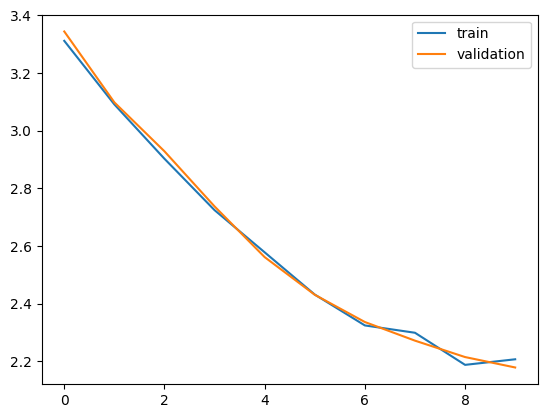

In [16]:

# Configuration for the language model
MODEL_PARAMS = {
    'vocab_size': vocab_size,
    'embedding_dim': 128,
    'attention_heads': 8,
    'sequence_length': 64,
    'transformer_blocks': 6,
    'training_batch': 64,
    'training_epochs': 100,
    'logging_frequency': 10,
    'dropout': 0.3,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}


# Check GPU availability and set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU for training.")
else:
    device = torch.device('cpu')
    print("GPU not found, using CPU for training.")

# Create the language model
if torch.cuda.device_count() > 1:
    print(f"Distributing training across {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(LLama(MODEL_PARAMS)).to(device)
else:
    model = LLama(MODEL_PARAMS).to(device)

# Move the dataset to the selected device
dataset = dataset.to(device)

# Create the optimizer
optimizer = torch.optim.Adam(model.parameters())

start_time = time.time()
# Start training
train_model(model, optimizer, dataset, MODEL_PARAMS)
print(f"Model Training Duration: {time.time() - start_time:.2f} seconds")


# Second task result:



Model parameters: 7596396
Epoch 10/200 | Validation Loss: 4.1419 | Time: 1.99s
Epoch 20/200 | Validation Loss: 3.6380 | Time: 1.95s
Epoch 30/200 | Validation Loss: 3.3633 | Time: 1.96s
Epoch 40/200 | Validation Loss: 3.2812 | Time: 1.96s
Epoch 50/200 | Validation Loss: 3.2277 | Time: 2.00s
Epoch 60/200 | Validation Loss: 3.2045 | Time: 2.00s
Epoch 70/200 | Validation Loss: 3.1568 | Time: 2.04s
Epoch 80/200 | Validation Loss: 3.0340 | Time: 1.99s
Epoch 90/200 | Validation Loss: 2.8939 | Time: 2.00s
Epoch 100/200 | Validation Loss: 2.7424 | Time: 2.01s
Epoch 110/200 | Validation Loss: 2.6302 | Time: 2.02s
Epoch 120/200 | Validation Loss: 2.5243 | Time: 2.02s
Epoch 130/200 | Validation Loss: 2.4436 | Time: 2.06s
Epoch 140/200 | Validation Loss: 2.3715 | Time: 2.09s
Epoch 150/200 | Validation Loss: 2.3232 | Time: 2.04s
Epoch 160/200 | Validation Loss: 2.2682 | Time: 2.04s
Epoch 170/200 | Validation Loss: 2.2353 | Time: 2.02s
Epoch 180/200 | Validation Loss: 2.1857 | Time: 2.02s
Epoch 190/2

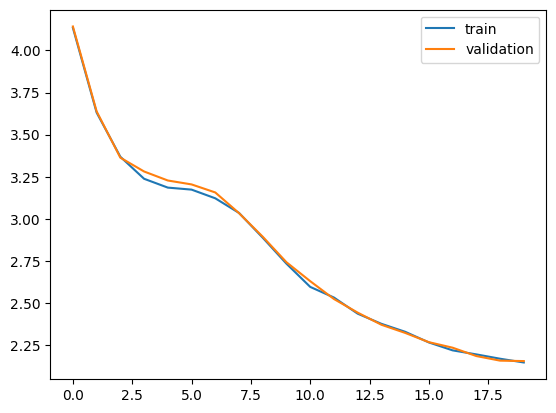

In [17]:
# Updated configuration for the language model
ENHANCED_MODEL_PARAMS = {
    'vocab_size': vocab_size,
    'embedding_dim': 256,
    'attention_heads': 16,
    'sequence_length': 128,
    'transformer_blocks': 16,
    'training_batch': 64,
    'training_epochs': 200,
    'logging_frequency': 10,
    'lr':1e-4,
    'dropout': 0.3,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

# Create the enhanced language model
if torch.cuda.device_count() > 1:
    print(f"Distributing training across {torch.cuda.device_count()} GPUs.")
    enhanced_model = nn.DataParallel(LLama(ENHANCED_MODEL_PARAMS)).to(device)
else:
    enhanced_model = LLama(ENHANCED_MODEL_PARAMS).to(device)

# Create the optimizer for the enhanced model
enhanced_optimizer = torch.optim.Adam(enhanced_model.parameters(), lr=ENHANCED_MODEL_PARAMS['lr'])

# Start training the enhanced model and note the training duration
start_time = time.time()
train_model(enhanced_model, enhanced_optimizer, dataset, ENHANCED_MODEL_PARAMS)
print(f"Enhanced Model Training Duration: {time.time() - start_time:.2f} seconds")

almost no improvement

##Key-Value (KV) caching

In [18]:
class AttentionHeadWithRoPE(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        self.w_q = nn.Linear(params['embedding_dim'], params['embedding_dim'], bias=False)
        self.w_k = nn.Linear(params['embedding_dim'], params['embedding_dim'], bias=False)
        self.w_v = nn.Linear(params['embedding_dim'], params['embedding_dim'], bias=False)
        self.rotation_matrix = generate_rotation_matrix(params['sequence_length'], params['embedding_dim'], params['device'])
        self.cache_k = None
        self.cache_v = None

    def forward(self, data_input, use_cache=True, return_attention=False):
        batch_size, seq_len, embed_dim = data_input.shape
        query = self.w_q(data_input)
        key = self.w_k(data_input)
        value = self.w_v(data_input)

        query_rotated = (torch.bmm(query.transpose(0, 1), self.rotation_matrix[:seq_len])).transpose(0, 1)
        key_rotated = (torch.bmm(key.transpose(0, 1), self.rotation_matrix[:seq_len])).transpose(0, 1)

        if use_cache and self.cache_k is not None and self.cache_v is not None:
            key_rotated = torch.cat([self.cache_k.detach(), key_rotated], dim=1)
            value = torch.cat([self.cache_v.detach(), value], dim=1)
        else:
            self.cache_k = key_rotated
            self.cache_v = value

        attention_output = F.scaled_dot_product_attention(
            query_rotated, key_rotated, value, dropout_p=0.1, is_causal=True
        )


        if return_attention:
            att_mask = torch.tril(torch.ones((seq_len, seq_len)), diagonal=0)
            attention_weights = (torch.bmm(query_rotated, key_rotated.transpose(1, 2)) / np.sqrt(embed_dim)) + att_mask

            attention_weights = F.softmax(attention_weights, dim=-1)
            return attention_output, attention_weights

        return attention_output


Using GPU for training.
Model parameters: 763362
Epoch 10/100 | Validation Loss: 3.7217 | Time: 0.22s
Epoch 20/100 | Validation Loss: 3.0108 | Time: 0.21s
Epoch 30/100 | Validation Loss: 2.8355 | Time: 0.22s
Epoch 40/100 | Validation Loss: 2.7642 | Time: 0.21s
Epoch 50/100 | Validation Loss: 2.6840 | Time: 0.22s
Epoch 60/100 | Validation Loss: 2.6257 | Time: 0.23s
Epoch 70/100 | Validation Loss: 2.6129 | Time: 0.21s
Epoch 80/100 | Validation Loss: 2.5718 | Time: 0.22s
Epoch 90/100 | Validation Loss: 2.5473 | Time: 0.23s
Epoch 100/100 | Validation Loss: 2.5254 | Time: 0.22s
Final Validation Loss:  2.525415229797363
Model Training Duration: 3.75 seconds


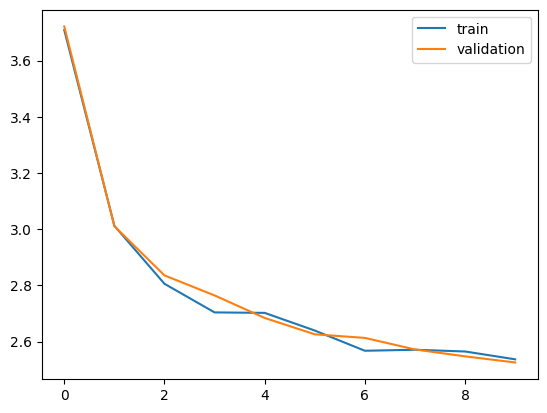

In [19]:
# Configuration for the language model
MODEL_PARAMS = {
    'vocab_size': vocab_size,
    'embedding_dim': 128,
    'attention_heads': 8,
    'sequence_length': 64,
    'transformer_blocks': 6,
    'training_batch': 64,
    'training_epochs': 100,
    'logging_frequency': 10,
    'dropout': 0.3,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}


# Check GPU availability and set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU for training.")
else:
    device = torch.device('cpu')
    print("GPU not found, using CPU for training.")

# Create the language model
if torch.cuda.device_count() > 1:
    print(f"Distributing training across {torch.cuda.device_count()} GPUs.")
    model_KV = nn.DataParallel(LLama(MODEL_PARAMS)).to(device)
else:
    model_KV = LLama(MODEL_PARAMS).to(device)

# Move the dataset to the selected device
dataset = dataset.to(device)

# Create the optimizer
optimizer = torch.optim.Adam(model_KV.parameters())

start_time = time.time()
# Start training
train_model(model_KV, optimizer, dataset, MODEL_PARAMS)
print(f"Model Training Duration: {time.time() - start_time:.2f} seconds")

the model runs 3.75 seconds , almost half of the first model
also we can notice that the loss dacays really fastly

## Grouped Query Attention (GQA)

In [20]:
class AttentionHeadWithGQA(nn.Module):
    def __init__(self, params, query_groups):
        super().__init__()
        self.params = params
        self.query_groups = params['query_groups']
        self.w_q = nn.Linear(params['embedding_dim'], params['embedding_dim'], bias=False)
        self.w_k = nn.Linear(params['embedding_dim'], params['embedding_dim'], bias=False)
        self.w_v = nn.Linear(params['embedding_dim'], params['embedding_dim'], bias=False)
        self.rotation_matrix = generate_rotation_matrix(params['sequence_length'], params['embedding_dim'], params['device'])

    def forward(self, data_input, return_attention=False):
        batch_size, seq_len, embed_dim = data_input.shape
        query = self.w_q(data_input).view(batch_size, seq_len, self.query_groups, -1)
        key = self.w_k(data_input)
        value = self.w_v(data_input)

        query_rotated = (torch.bmm(query.transpose(0, 1), self.rotation_matrix[:seq_len])).transpose(0, 1)
        key_rotated = (torch.bmm(key.transpose(0, 1), self.rotation_matrix[:seq_len])).transpose(0, 1)

        attention_output = F.scaled_dot_product_attention(
            query_rotated, key_rotated, value, dropout_p=0.1, is_causal=True
        )

        return attention_output.view(batch_size, seq_len, embed_dim)


Using GPU for training.
Model parameters: 763362
Epoch 10/100 | Validation Loss: 3.7182 | Time: 0.22s
Epoch 20/100 | Validation Loss: 3.0314 | Time: 0.21s
Epoch 30/100 | Validation Loss: 2.8277 | Time: 0.23s
Epoch 40/100 | Validation Loss: 2.7070 | Time: 0.21s
Epoch 50/100 | Validation Loss: 2.6620 | Time: 0.22s
Epoch 60/100 | Validation Loss: 2.6183 | Time: 0.23s
Epoch 70/100 | Validation Loss: 2.5793 | Time: 0.22s
Epoch 80/100 | Validation Loss: 2.5622 | Time: 0.22s
Epoch 90/100 | Validation Loss: 2.5442 | Time: 0.23s
Epoch 100/100 | Validation Loss: 2.5485 | Time: 0.21s
Final Validation Loss:  2.5485157489776613
Model GQA Training Duration: 3.85 seconds


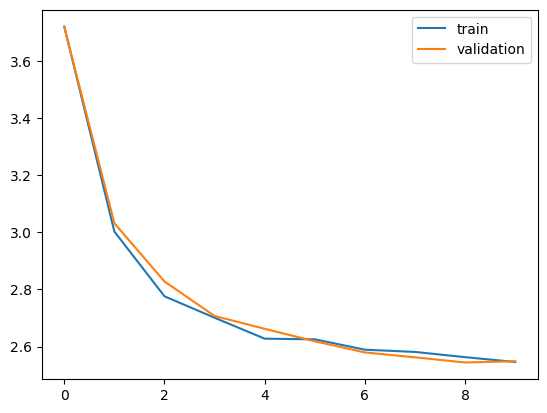

In [21]:
# Configuration for the language model
MODEL_PARAMS = {
    'vocab_size': vocab_size,
    'embedding_dim': 128,
    'attention_heads': 8,
    'sequence_length': 64,
    'transformer_blocks': 6,
    'training_batch': 64,
    'training_epochs': 100,
    'logging_frequency': 10,
    'dropout': 0.3,
    'query_groups':4,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}


# Check GPU availability and set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU for training.")
else:
    device = torch.device('cpu')
    print("GPU not found, using CPU for training.")

# Create the language model
if torch.cuda.device_count() > 1:
    print(f"Distributing training across {torch.cuda.device_count()} GPUs.")
    model_GQA = nn.DataParallel(LLama(MODEL_PARAMS)).to(device)
else:
    model_GQA = LLama(MODEL_PARAMS).to(device)

# Move the dataset to the selected device
dataset = dataset.to(device)

# Create the optimizer
optimizer = torch.optim.Adam(model_GQA.parameters())

start_time = time.time()
# Start training
train_model(model_GQA, optimizer, dataset, MODEL_PARAMS)
print(f"Model GQA Training Duration: {time.time() - start_time:.2f} seconds")

the model runs 2.5 seconds , almost the third of the first model
also we can notice that the loss dacays really fastly